0.9999999999802837


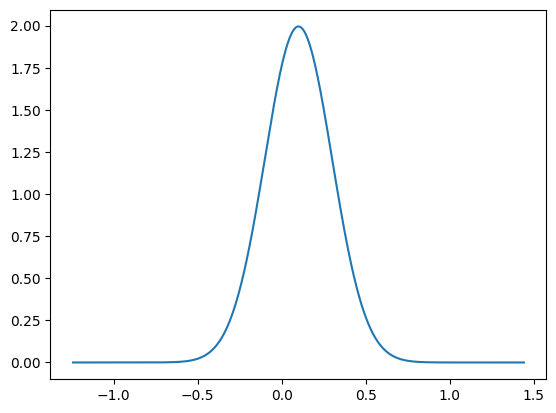

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import tntorch as tn

num_dimensions = 1
mu = 0.10   # Mean vector
cov_matrix = 0.20  # Covariance matrix 

#PARAMETRI DISCRETIZZAZIOINE

d = 10                 # qubit
m = 2**d               # dimensioni discretizzazione

#GAUSSIANA DISCRETA

domain_np = np.linspace(mu - 3*np.sqrt(cov_matrix), mu + 3*np.sqrt(cov_matrix), m)
def gaussian(x):
    return 1/(np.sqrt(2*np.pi)*cov_matrix) * np.exp(-0.5*(((x-mu)/cov_matrix)**2))


vec =  np.array([gaussian(x) for x in domain_np])    # vettore probabilità discreta

dx = domain_np[1] - domain_np[0]
I = np.trapezoid(vec, x = domain_np, dx = dx)
print(I)
plt.plot(domain_np,vec)

In [2]:
shape = (2,)*d         # (2,2,2,2)
A = vec.reshape(shape) #tensore numpy
T=tn.Tensor(A)      #tensore torch


#CREAZIONE TENSOR TRAIN

TTrain = tn.cross(
    function=lambda x: x,   # identità su ciascuna fibra
    tensors=[T],            # lista di un solo tensore               # tolleranza desiderata
    ranks_tt=8,                 # rank massimo ammesso
)



print(TTrain)


cores_torch = TTrain.cores
cores = [c.cpu().numpy() for c in cores_torch]

print(cores[0].shape)
result = cores[0][0,:,:]
#print(len(cores))
#print(cores[0])
#print(cores[2].shape)

cross device is cpu
Functions that require cross-approximation can be accelerated with the optional maxvolpy package, which can be installed by 'pip install maxvolpy'. More info is available at https://bitbucket.org/muxas/maxvolpy.
Cross-approximation over a 10D domain containing 1024 grid points:
iter: 0  | eps: 1.760e-08 | time:   0.0451 | largest rank:   8 <- converged: eps < 1e-06
Did 1356 function evaluations, which took 1.478e-05s (9.173e+07 evals/s)

10D TT tensor:

  2   2   2   2   2   2   2   2   2   2
  |   |   |   |   |   |   |   |   |   |
 (0) (1) (2) (3) (4) (5) (6) (7) (8) (9)
 / \ / \ / \ / \ / \ / \ / \ / \ / \ / \
1   2   4   8   8   8   8   8   4   2   1

(1, 2, 2)


In [3]:
import numpy as np

def contract_tt_cores(cores):
    """
    Contrai sequenzialmente i TT‐cores lungo le dimensioni di rango.
    Input:
      cores: lista di numpy array di shape (r_{k-1}, i_k, r_k)
    Output:
      array numpy del tensore completo di shape (i_1, i_2, ..., i_d)
    """
    # Partiamo dal primo core, shape (r0, i1, r1), tipicamente r0=1
    result = cores[0]

    # Per ogni core successivo, contrae l'ultimo asse di result (r_k)
    # con il primo asse del nuovo core (stesso r_k)
    for C in cores[1:]:
        # axes=([-1], [0]) = ultimo asse di result con primo asse di C
        result = np.tensordot(result, C, axes=([-1], [0]))
        # dopo la tensordot, le modalità si dispongono in questo ordine:
        # (..., i_k, r_k) ⨂ (r_k, i_{k+1}, r_{k+1})
        # → (..., i_k, i_{k+1}, r_{k+1})
    
    # Alla fine r_d = 1, quindi eliminiamo le dim singleton
    return np.squeeze(result)


# Esempio d’uso
# cores è la tua lista di array numpy di shape (r_{k-1}, i_k, r_k)
full_tensor = contract_tt_cores(cores)

print("Shape ricostruita:", full_tensor.shape)
# Dovrebbe stampare (2,2,2,2,2,2,2,2,2,2) per d=10 e tutti i modi di dimensione 2

Shape ricostruita: (2, 2, 2, 2, 2, 2, 2, 2, 2, 2)


1.4104739586137005
537.7426186580647


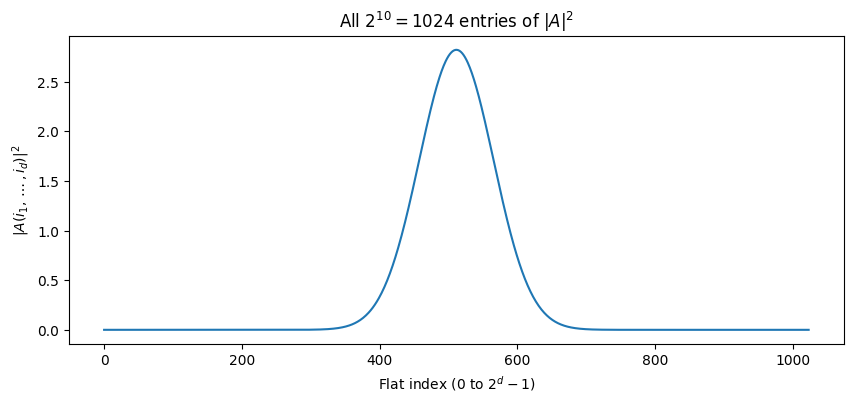

In [4]:
d = full_tensor.ndim  # order of the tensor
N = 2**d

# Flatten and compute |A|^2
values = full_tensor.flatten()                # length 2^d
probs = np.abs(values[:])**2                  # squared magnitudes

I = np.trapezoid(probs, x = domain_np, dx = dx)
print(I)

print(np.sum(probs))
# Plot
plt.figure(figsize=(10,4))
plt.plot(np.arange(N), probs/I)
plt.xlabel('Flat index (0 to $2^d-1$)')
plt.ylabel(r'$|A(i_1,\dots,i_d)|^2$')
plt.title(f'All $2^{{{d}}}={N}$ entries of $|A|^2$')
plt.show()

381.24959015653474


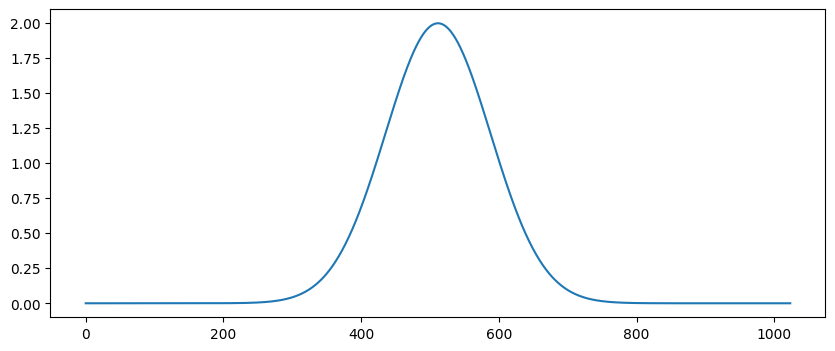

In [5]:
plt.figure(figsize=(10,4))
print(np.sum(vec))
plt.plot(np.arange(N),vec)

0.08302866599447944


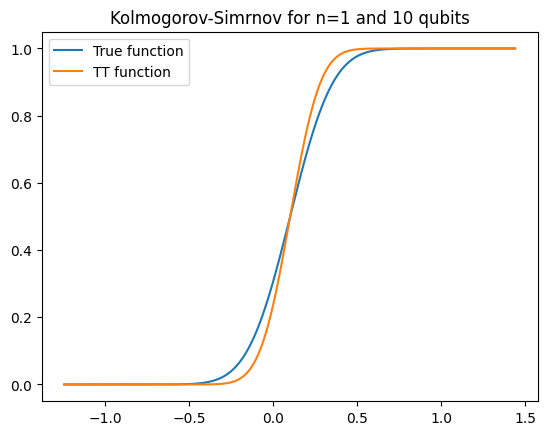

In [6]:
F = np.zeros(len(vec))
G = np.zeros(len(vec))
for x in range(N):
    
    F[x] = np.trapezoid(vec[:x],x = domain_np[:x], dx = dx)
    G[x] = np.trapezoid(probs[:x]/I,x = domain_np[:x], dx = dx)


plt.plot(domain_np,F,label='True function')
plt.plot(domain_np,G,label='TT function')
plt.title('Kolmogorov-Simrnov for n=1 and 10 qubits')
plt.legend()

D = np.max(np.abs(F-G))
print(D)